# Setup

In [1]:
import itertools

import pandas as pd
import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.stats.stattools import durbin_watson

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
plot_params = {'legend.fontsize': 20,
               'figure.figsize': (20, 10),
               'axes.labelsize':  15,
               'axes.titlesize':  30,
               'xtick.labelsize': 15,
               'ytick.labelsize': 15,
               'figure.dpi': 300}

plt.style.use('seaborn-v0_8')

plt.rcParams.update(plot_params)

color_dark_blue = [1/255, 62/255, 125/255]
color_light_blue = [6/255, 143/255, 203/255]
purple = [102/255, 51/255, 153/255]

colors = [color_dark_blue, color_light_blue, purple]

color_line = list(itertools.product(['-', ':', '--', ':' '-', ':'], colors))

# Load Data

In [6]:
df = pd.read_csv('df_NS.csv', index_col=0)
df.index = pd.DatetimeIndex(df.index).to_period('D')

n = len(df)
train_df = df[0:int(n*0.8)]
val_df = df[int(n*0.8):int(n*0.9)]
test_df = df[int(n*0.9):]

<Axes: xlabel='Date'>

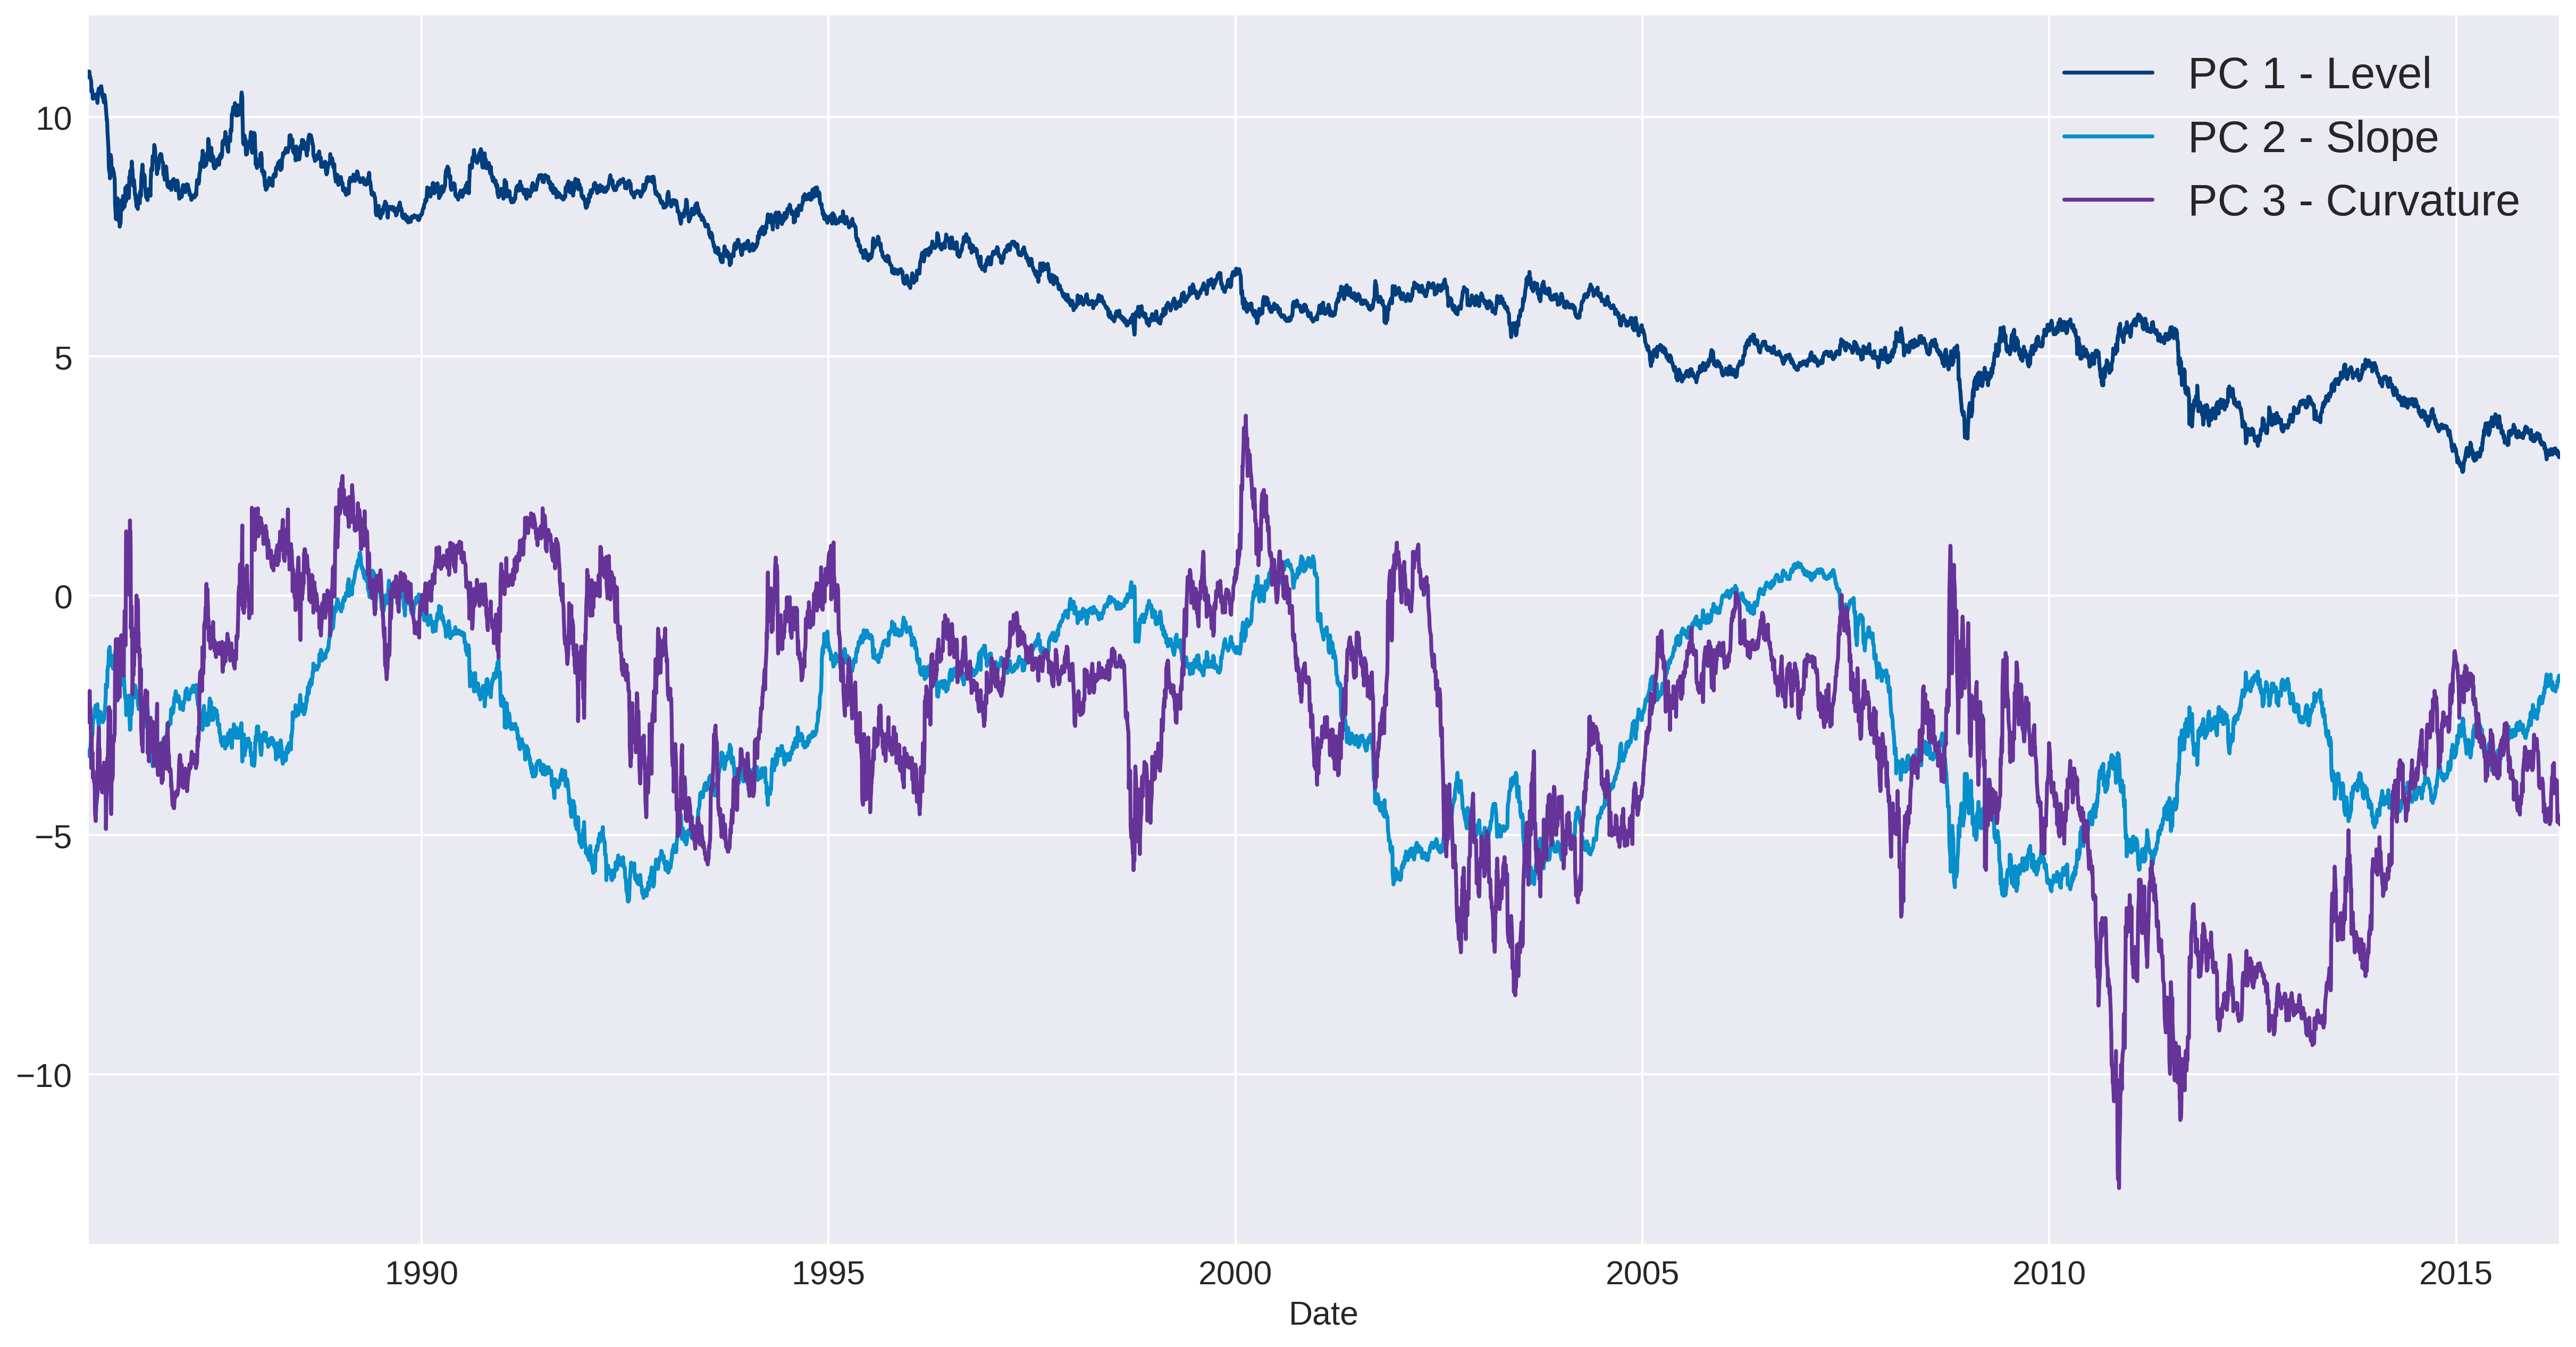

In [7]:
train_df.plot(color=colors)

# Augmented Dickey–Fuller Stationarity Test

In [8]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [9]:
# ADF Test on each column
for name, column in train_df.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "PC 1 - Level" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.7888
 No. Lags Chosen       = 27
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.386. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "PC 2 - Slope" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.072
 No. Lags Chosen       = 1
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.2559. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "PC 3 - Curvature" 
    -----------------------------------------------
 Null H

In [10]:
train_df_diff = train_df.diff().dropna()

<Axes: xlabel='Date'>

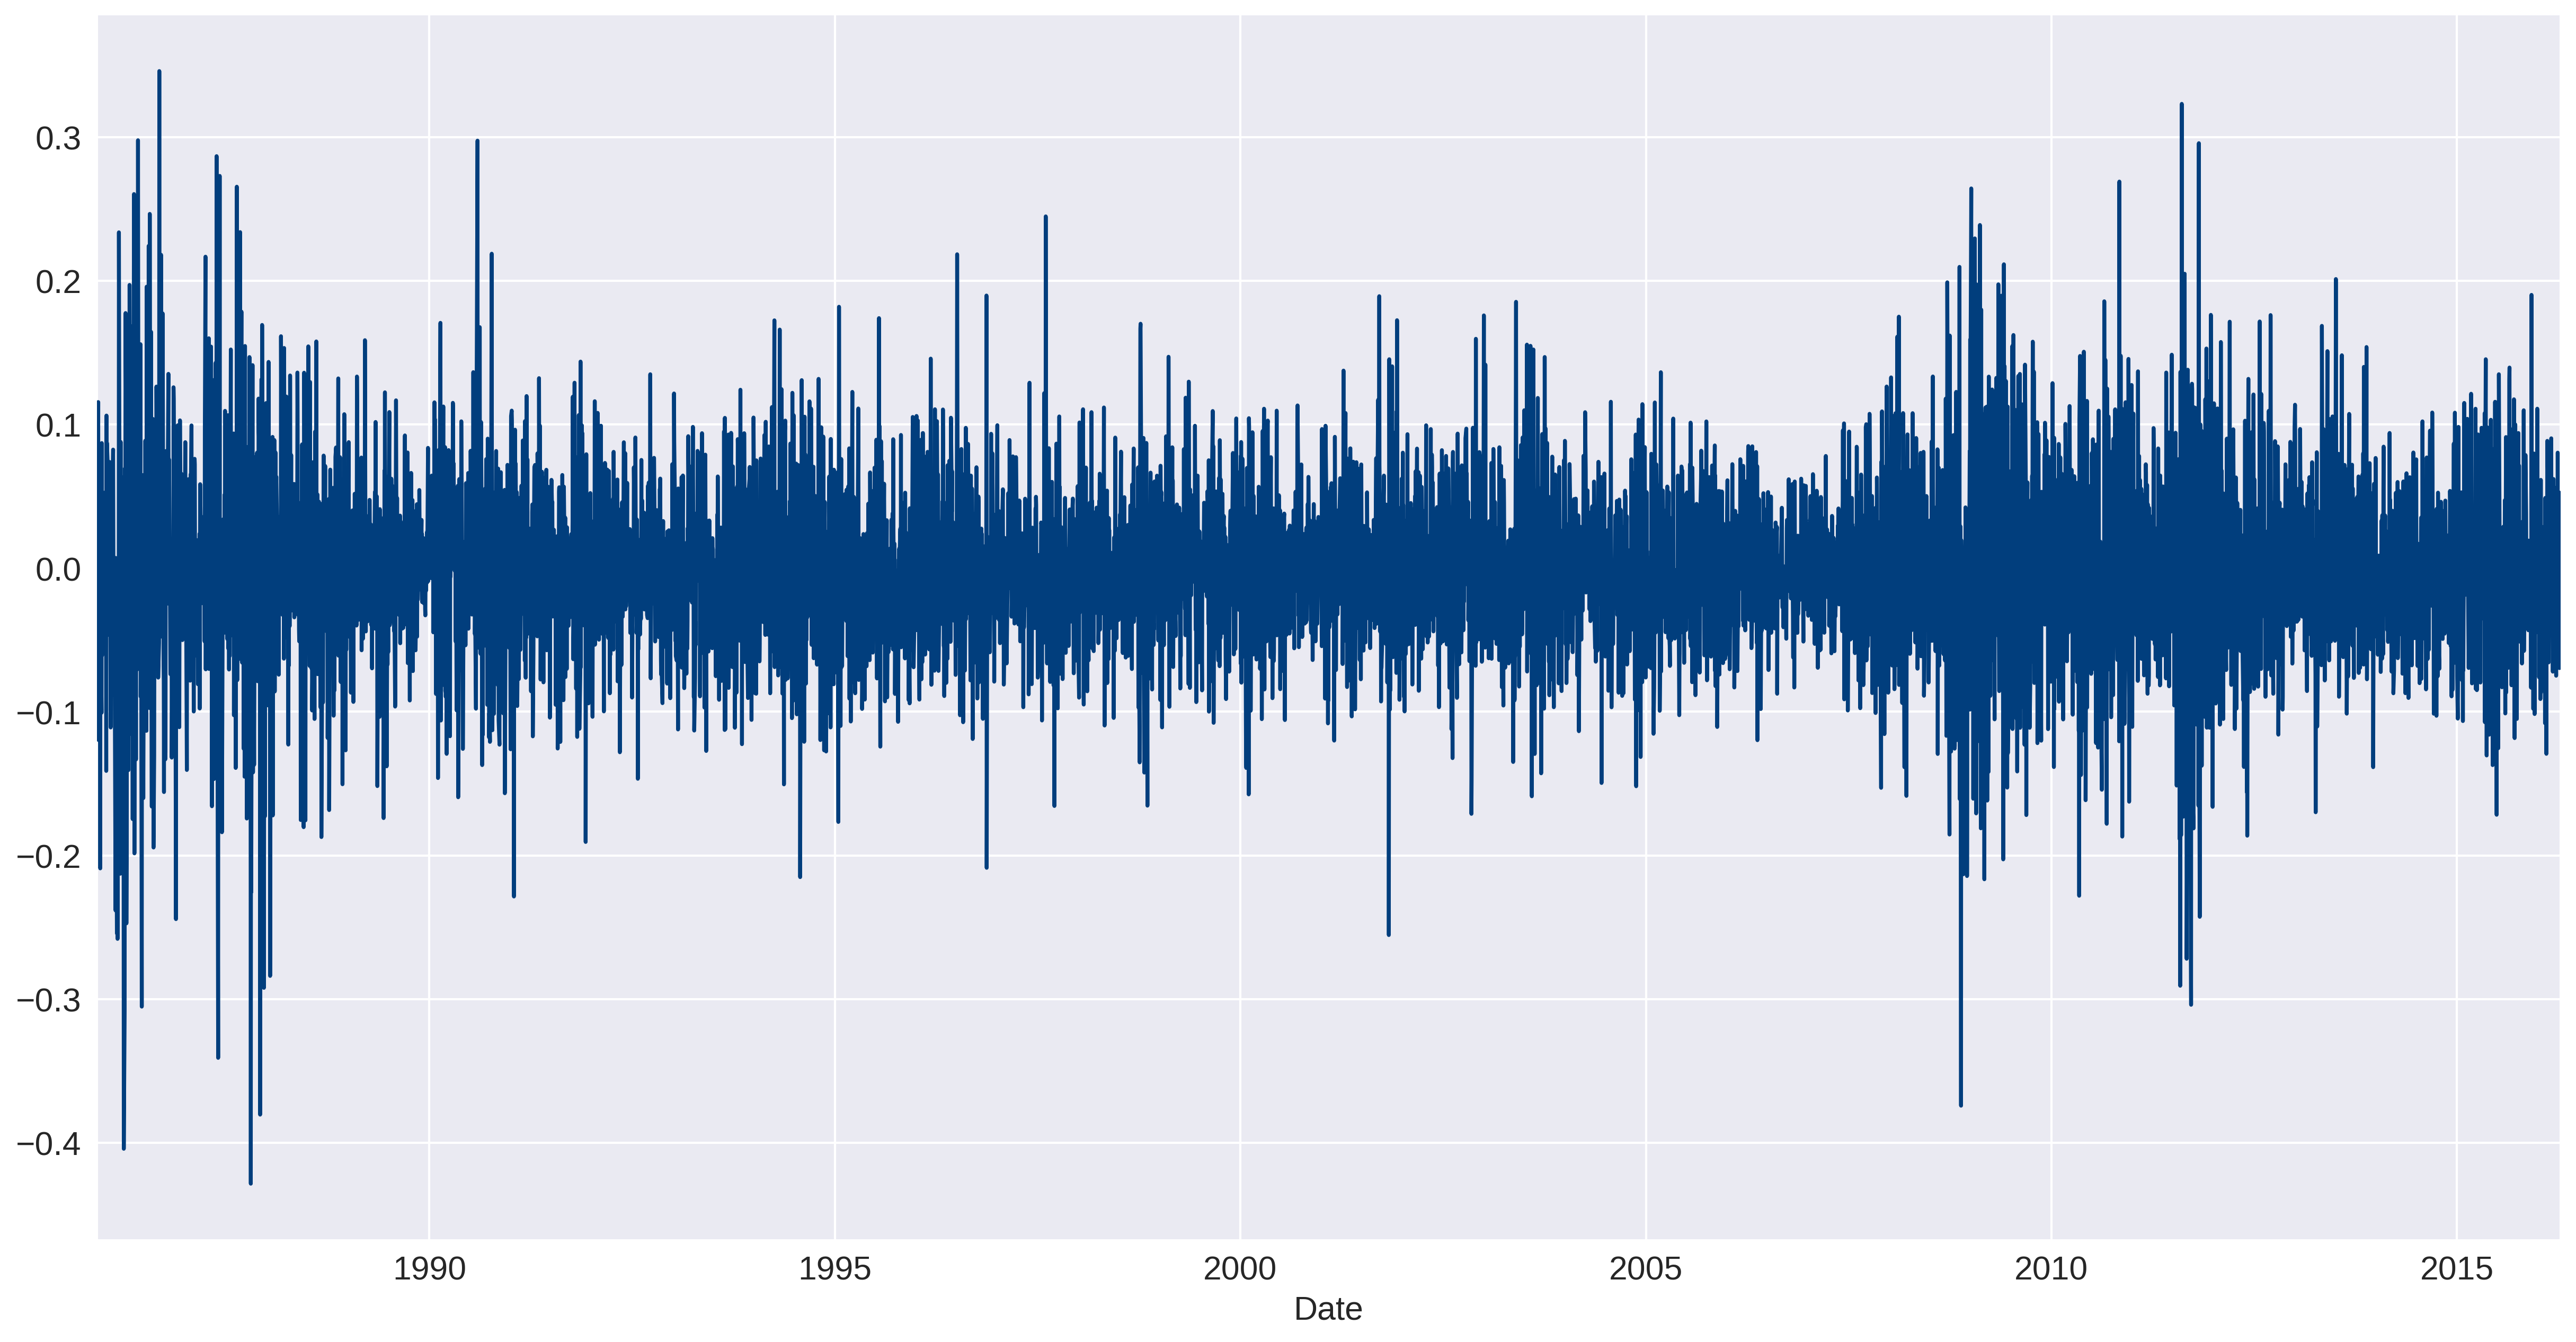

In [11]:
train_df_diff['PC 1 - Level'].plot(color=colors)

In [12]:
# ADF Test on each column
for name, column in train_df_diff.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "PC 1 - Level" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -16.727
 No. Lags Chosen       = 26
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "PC 2 - Slope" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -83.5589
 No. Lags Chosen       = 0
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "PC 3 - Curvature" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.


# Vector Autoregressive (VAR)

In [13]:
model = VAR(train_df_diff)

In [14]:
model.select_order(maxlags=15).summary()

,AIC,BIC,FPE,HQIC
0,-14.46,-14.46,5.240e-07,-14.46
1,-14.48,-14.46*,5.167e-07,-14.47*
2,-14.48,-14.46,5.161e-07,-14.47
3,-14.48,-14.45,5.163e-07,-14.47
4,-14.48,-14.44,5.156e-07,-14.47
5,-14.48,-14.43,5.161e-07,-14.46
6,-14.48,-14.42,5.167e-07,-14.46
7,-14.48*,-14.42,5.152e-07*,-14.46
8,-14.48,-14.41,5.160e-07,-14.45
9,-14.48,-14.40,5.166e-07,-14.45


In [15]:
model_fitted = model.fit()
lag_order = model_fitted.k_ar

In [16]:
lag_order

1

In [17]:
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 05, Mar, 2024
Time:                     01:13:19
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -14.4589
Nobs:                     7578.00    HQIC:                  -14.4662
Log likelihood:           22580.4    FPE:                5.19746e-07
AIC:                     -14.4699    Det(Omega_mle):     5.18924e-07
--------------------------------------------------------------------
Results for equation PC 1 - Level
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                      -0.001009         0.000687           -1.468           0.142
L1.PC 1 - Level             0.031245         0.016385            1.907           0.057
L1.PC 2 - Slope            -0

## Impulse Response Function

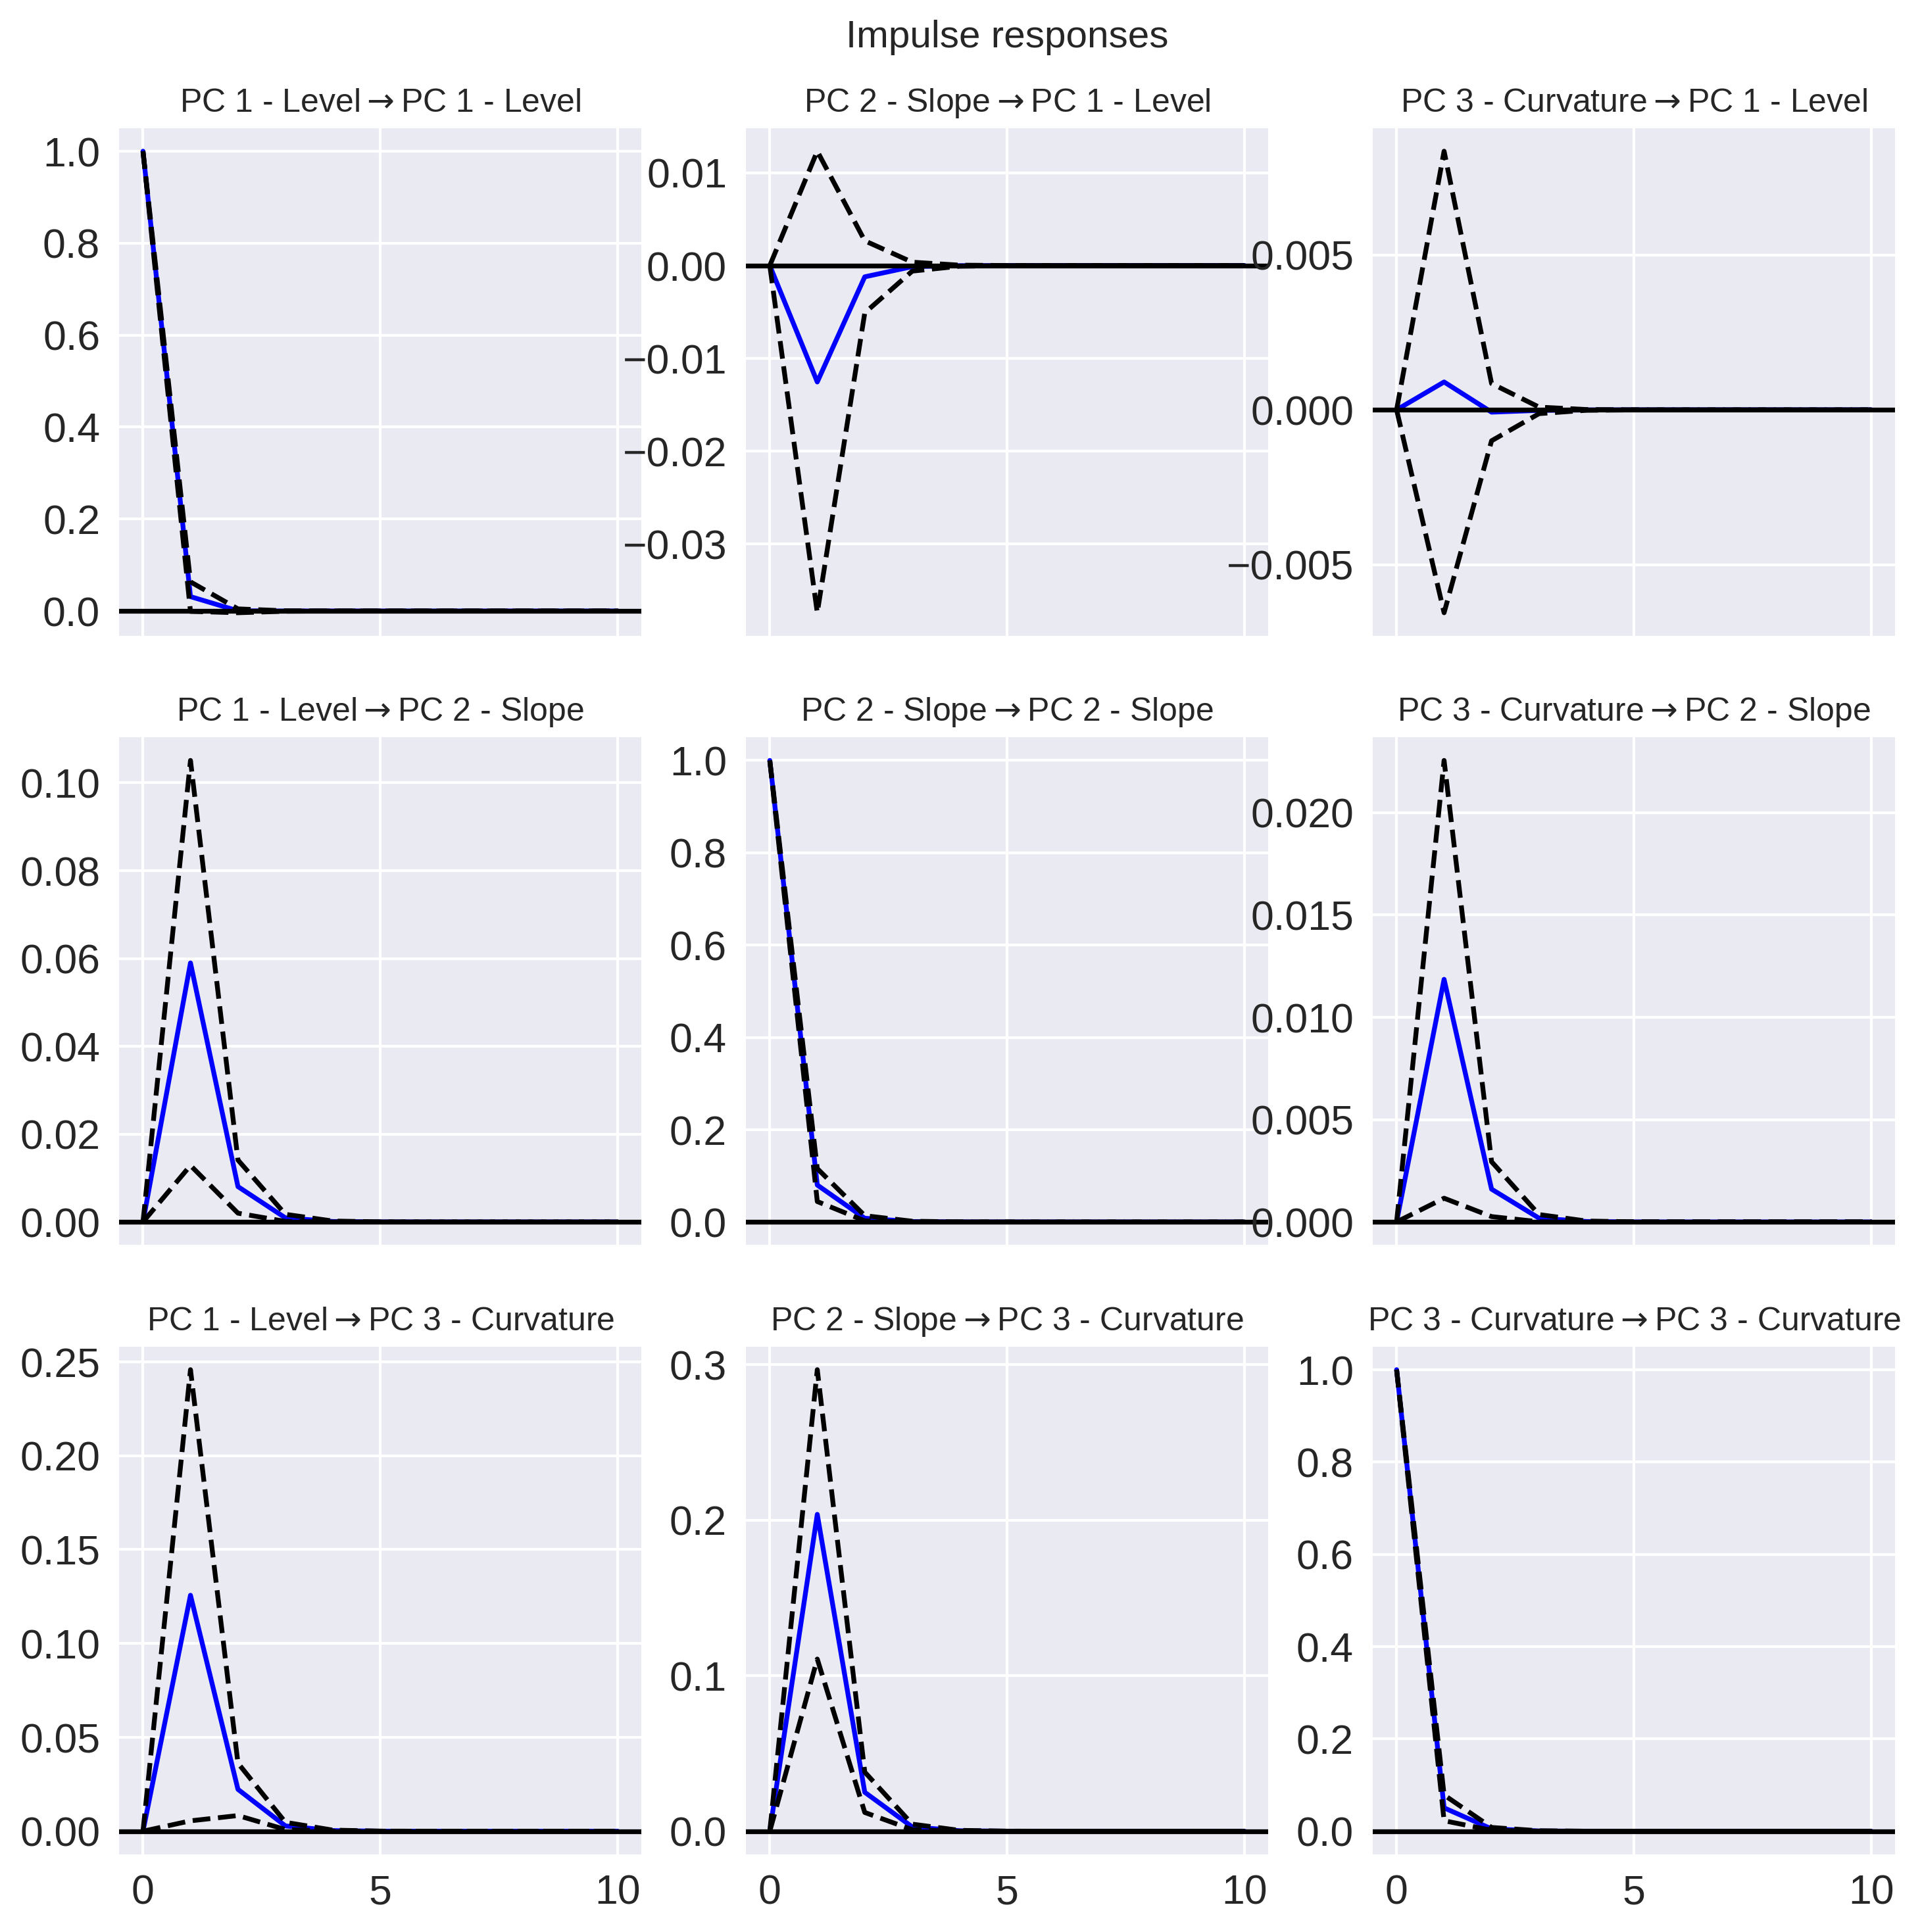

In [18]:
irf = model_fitted.irf(10)
_ = irf.plot(orth=False)

## Granger's Causality

In [ ]:
def grangers_causation_matrix(data, variables, test='ssr_chi2test', maxlag=8):
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table
    are the P-Values. P-Values lesser than the significance level (0.05), implies
    the Null Hypothesis that the coefficients of the corresponding past values is
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [ ]:
grangers_causation_matrix(train_df_diff, variables = train_df_diff.columns)

,PC 1 - Level_x,PC 2 - Slope_x,PC 3 - Curvature_x
PC 1 - Level_y,1.0000,0.0232,0.0555
PC 2 - Slope_y,0.0000,1.0000,0.0568
PC 3 - Curvature_y,0.0406,0.0001,1.0000


# Forecasting

## Validation

In [ ]:
def invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        df_fc[str(col)+' forecast'] = df_train[str(col)].iloc[-1] + df_fc[str(col)].cumsum()
    return df_fc

In [ ]:
val_df_diff = val_df.diff().dropna()

forecast_window = 1

df_results = pd.DataFrame(columns=train_df_diff.columns, index=val_df.index)

df_forecast = pd.DataFrame(columns=train_df_diff.columns, index=val_df.index)

forecast_input = train_df_diff.values[-lag_order:]
fc = model_fitted.forecast(y=forecast_input, steps=forecast_window)
df_forecast.iloc[0,:] = fc
df_results.iloc[0,:] = train_df.iloc[-1,:].values + fc[0]

for i in range(1,len(val_df)):

    forecast_input = val_df_diff.values[i-lag_order:i]
    fc = model_fitted.forecast(y=forecast_input, steps=forecast_window)
    df_forecast.iloc[i,:] = fc

    df_results.iloc[i,:] = val_df.iloc[i-1,:] + fc[0]

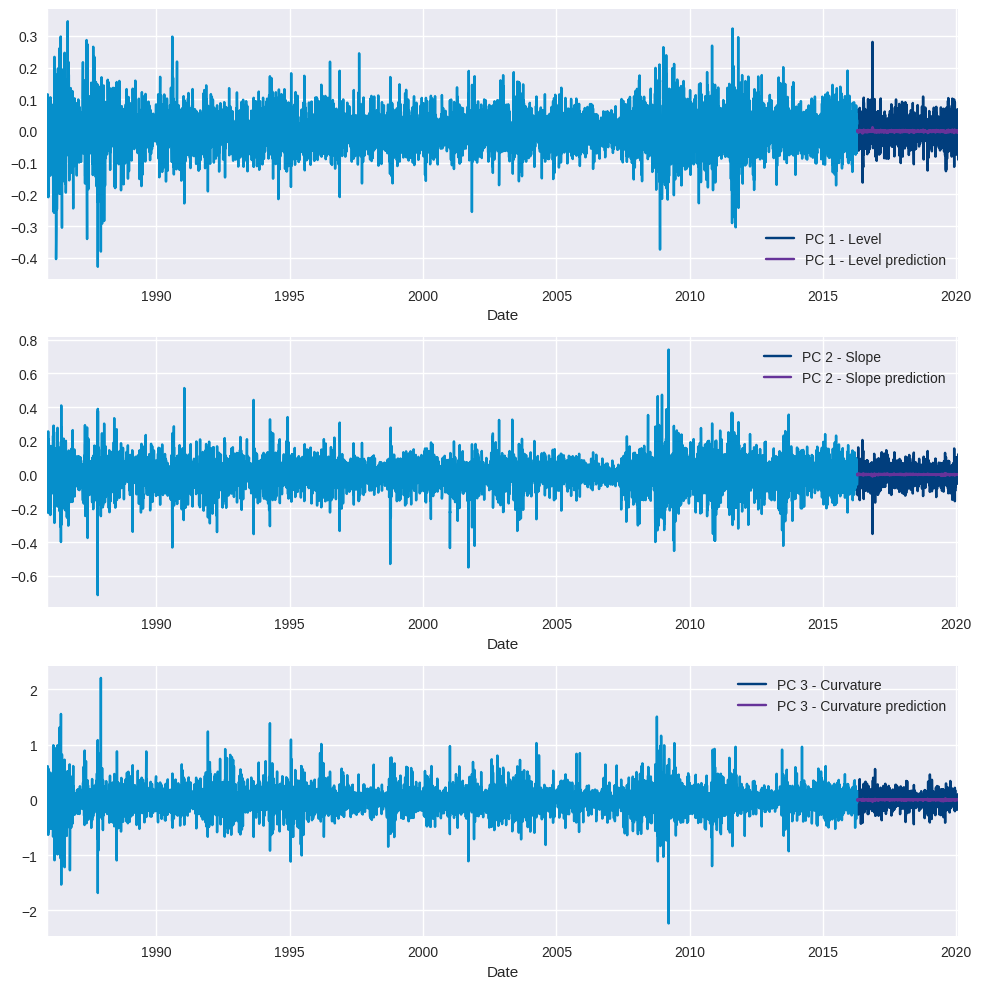

In [ ]:
fig, axes = plt.subplots(nrows=3,figsize=(10,10))
for i, (col,ax) in enumerate(zip(train_df_diff.columns, axes.flatten())):
    val_df_diff[col].plot(legend=True, ax=ax, color=color_dark_blue);
    train_df_diff[col].plot(legend=False, ax=ax, color=color_light_blue);
    df_forecast[col].plot(legend=True, ax=ax, color=purple, label=col+ ' prediction').autoscale(axis='x',tight=True);

plt.tight_layout();

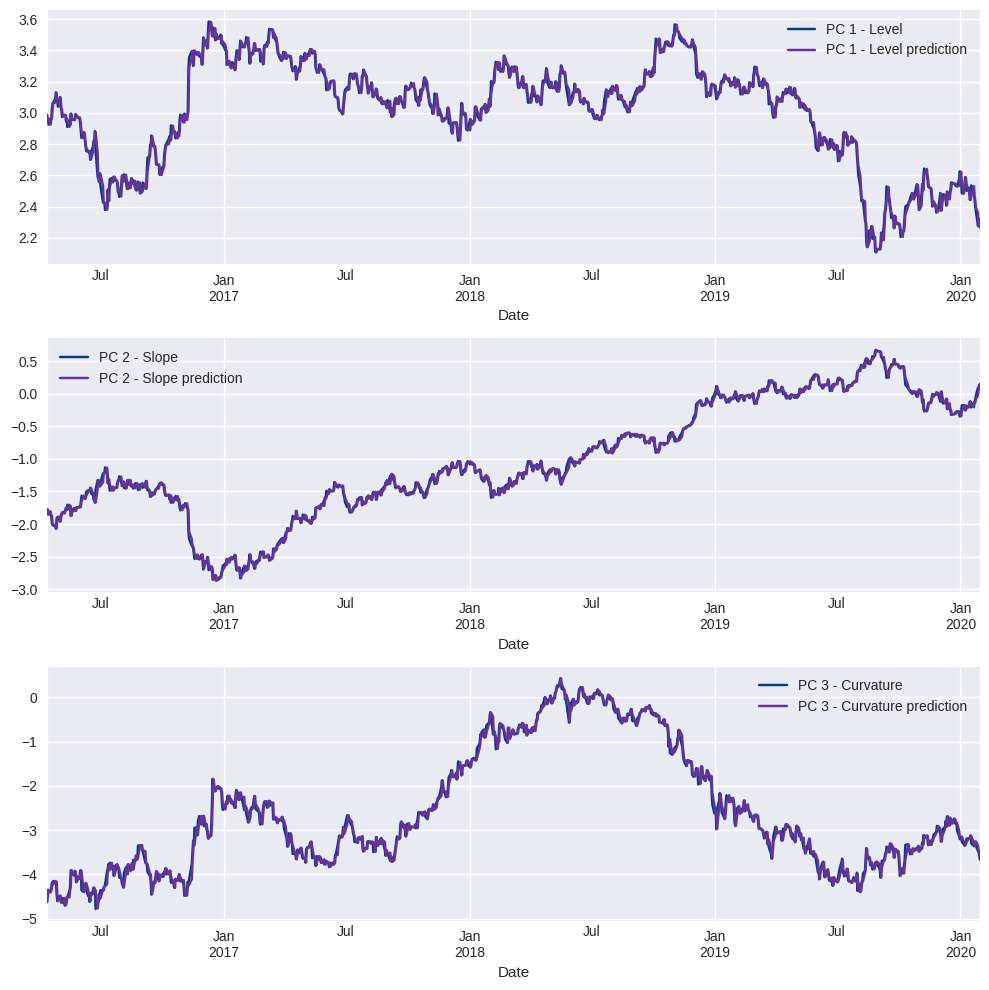

In [ ]:
fig, axes = plt.subplots(nrows=3,figsize=(10,10))
for i, (col,ax) in enumerate(zip(train_df_diff.columns, axes.flatten())):
    val_df[col].plot(legend=True, ax=ax, color=color_dark_blue);
    #train_df[col].plot(legend=False, ax=ax, color=color_light_blue);
    df_results[col].plot(legend=True, ax=ax, color=purple, label=col+ ' prediction').autoscale(axis='x',tight=True);

plt.tight_layout();

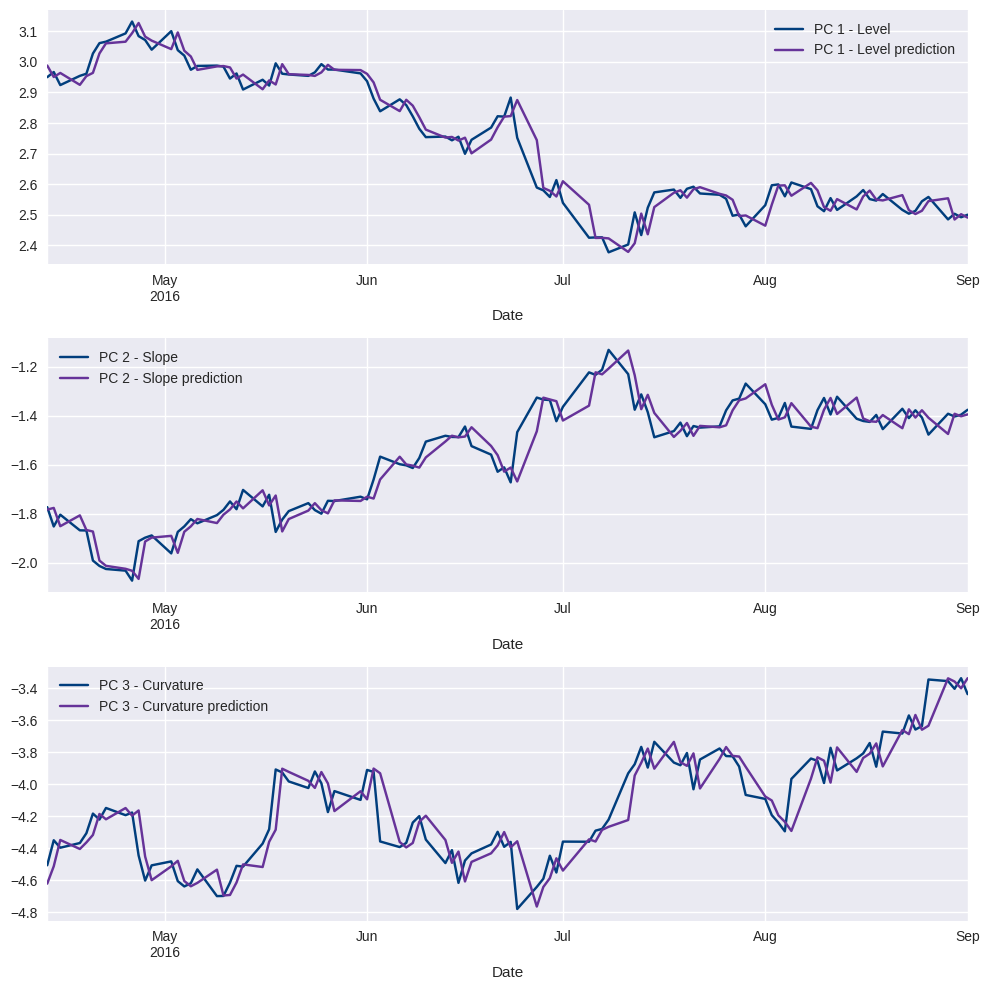

In [ ]:
fig, axes = plt.subplots(nrows=3,figsize=(10,10))
for i, (col,ax) in enumerate(zip(train_df_diff.columns, axes.flatten())):
    val_df[col].iloc[:100].plot(legend=True, ax=ax, color=color_dark_blue);
    #train_df[col].plot(legend=False, ax=ax, color=color_light_blue);
    df_results[col].iloc[:100].plot(legend=True, ax=ax, color=purple, label=col+ ' prediction').autoscale(axis='x',tight=True);

plt.tight_layout();